In [31]:
import csv
import requests
import xml.etree.ElementTree as ET
import copy
from glob import glob
import os
from tqdm import tqdm
import jsonlines
import sys
import json
from rouge_score import rouge_scorer
from nltk.corpus import stopwords
from nltk import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datasets import load_from_disk, load_dataset, load_metric

In [2]:
stops = set(stopwords.words('english'))

In [3]:
def remove_stop_words(sentence):
    tokens = word_tokenize(sentence)
    cleaned_tokens = []
    for token in tokens:
        if token not in stops:
            cleaned_tokens.append(token)
    return " ".join(cleaned_tokens)

In [4]:
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2'], use_stemmer=True)
rouge = load_metric("rouge")

In [5]:
def ROUGE(predictions, references, use_stemmer=True):
    result = rouge.compute(predictions=predictions, references=references, use_stemmer=use_stemmer)
    return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}

In [6]:
def ROUGE_recall(predictions, references, use_stemmer=True):
    result = rouge.compute(predictions=predictions, references=references, use_stemmer=use_stemmer)
    return {k: round(v.mid.recall * 100, 4) for k, v in result.items()}

In [7]:
CTS_annotations = []
with open("CitationSupport.jsonl") as f:
    for line in f:
        CTS_annotations.append(json.loads(line))
        

In [8]:
CTS_by_citation = {}
for annotation in CTS_annotations:
    if "citing_sentence" in annotation:
        ID = annotation["citing_paper"] + "_" + annotation["cids"]
        this_citation = CTS_by_citation.get(ID,{
            "id": ID,
            "citing_sentence": annotation["citing_sentence"],
            "citing_paper": annotation["citing_paper"],
            "cited_papers": {},
        })
        this_cited_paper = this_citation["cited_papers"].get(annotation["cited_paper"], {
            "cited_paper": annotation["cited_paper"],
            "citation_marker": annotation["citation_marker"],
            "support_sentences": set([]),
        })
        this_cited_paper["support_sentences"].add(annotation["support_sentence"])
        this_citation["cited_papers"][annotation["cited_paper"]] = this_cited_paper
        CTS_by_citation[ID] = this_citation

In [9]:
len(CTS_by_citation)

150

In [10]:
CTS_by_citation['C08-1013_36']["cited_papers"]

{'Bannard-and-Callison-Burch-2005': {'cited_paper': 'Bannard-and-Callison-Burch-2005',
  'citation_marker': 'Bannard and Callison-Burch (2005)',
  'support_sentences': {'Indeed our judges thought the meaning of the paraphrases to be correct in 64.5% of cases.',
   'Paraphrases that were judged to preserve both meaning and grammaticality were considered to be correct, and examples which failed on either judgment were considered to be incorrect.',
   'We created a total of 289 such evaluation sets, with a total of 1366 unique sentences created through substitution.',
   'We had two native English speakers produce judgments as to whether the new sentences preserved the meaning of the original phrase and as to whether they remained grammatical.',
   'We use the heuristic for phrase alignment described in Och and Ney (2003) which aligns phrases by incrementally building longer phrases from words and phrases which have adjacent alignment points.'}}}

In [11]:
paper_paths = glob(os.path.join("BasicCorpus","*"))

In [12]:
all_paper_paths = []
for path in paper_paths:
    paper_subpaths = glob(os.path.join(path,"*"))
    all_paper_paths.extend(paper_subpaths)

In [13]:
len(all_paper_paths)

239

In [14]:
reading_error = 0
all_sentences = {}
cleaned_sentence_map = {}
for paper_path in all_paper_paths:
    try:
        paper_id = paper_path.split("/")[-1].replace(".xml","")
        tree = ET.parse(paper_path)
        root = tree.getroot()
        sentences = []
        for node in root.findall("Sentence"):
            sentence = node.text.strip().replace("  "," ")
            sentences.append(sentence)
            cleaned_sentence_map[sentence] = remove_stop_words(sentence)
        all_sentences[paper_id] = sentences
    except:
        
        reading_error += 1
        print(reading_error, paper_path)

1 BasicCorpus/C08-1013/C08-1013.xml
2 BasicCorpus/N09-1019/Li-et-al.,-2004.xml
3 BasicCorpus/N09-1019/Chinchor,-1998.xml
4 BasicCorpus/N09-1019/N09-1019.xml
5 BasicCorpus/N09-1019/Riloff-and-Jones,-1999.xml
6 BasicCorpus/N09-1019/Black-et-al.-1998.xml
7 BasicCorpus/P08-1032/Smeulders-et-al.,-2000.xml
8 BasicCorpus/P08-1032/P08-1032.xml
9 BasicCorpus/P08-1032/Vailaya-et-al.,-2001.xml
10 BasicCorpus/N09-1027/N09-1027.xml
11 BasicCorpus/p343-ko/13.xml
12 BasicCorpus/p343-ko/p343-ko.xml
13 BasicCorpus/p343-ko/26.xml
14 BasicCorpus/p343-ko/2.xml
15 BasicCorpus/N09-1034/Ristad-and-Yianilos,-1998.xml
16 BasicCorpus/N09-1034/Jung-et-al.,-2000.xml
17 BasicCorpus/N09-1034/N09-1034.xml
18 BasicCorpus/P08-1027/Nastase-et-al.,-2006.xml
19 BasicCorpus/P08-1027/P08-1027.xml
20 BasicCorpus/P08-1027/Strube-and-Ponzetto,-2006.xml
21 BasicCorpus/p203-wu/p203-wu.xml
22 BasicCorpus/p203-wu/23.xml
23 BasicCorpus/p203-wu/24.xml
24 BasicCorpus/C08-1064/C08-1064.xml
25 BasicCorpus/p27-kalashnikov/8.xml
26 Basi

In [15]:
for citation_id, citation in tqdm(CTS_by_citation.items()):
    citing_sentence = remove_stop_words(citation["citing_sentence"])
    for cited_paper_id, cited_paper in citation["cited_papers"].items():
        sentence_scores = []
        if cited_paper_id in all_sentences:
            for sentence in all_sentences[cited_paper_id]:
                scores = scorer.score(citing_sentence, cleaned_sentence_map[sentence])
                performance = (scores["rouge1"].recall + scores["rouge2"].recall) / 2
                sentence_scores.append(performance)
            cited_paper["sentence_scores"] = sentence_scores

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:09<00:00,  2.16it/s]


In [16]:
for citation_id, citation in CTS_by_citation.items():
    all_candidate_sentences = []
    all_sentence_scores = []
    all_support_sentences = []
    for cited_paper_id, cited_paper in citation["cited_papers"].items():
        if "sentence_scores" in cited_paper:
            all_candidate_sentences.extend(all_sentences[cited_paper_id])
            all_sentence_scores.extend(cited_paper["sentence_scores"])
            assert(len(all_candidate_sentences) == len(all_sentence_scores))
        all_support_sentences.extend(cited_paper["support_sentences"])
    sorted_indices = np.argsort(all_sentence_scores)[::-1].tolist()
    all_sorted_sentences = []
    for idx in sorted_indices:
        all_sorted_sentences.append(all_candidate_sentences[idx])
    citation["sorted_support_sentences"] = all_sorted_sentences
    citation["all_support_sentences"] = all_support_sentences

In [17]:
n_sentences = []
for k,v in all_sentences.items():
    n_sentences.append(len(v))

In [70]:
scisumm_n_sentences = [191,
 113,
 176,
 200,
 154,
 147,
 415,
 194,
 114,
 203,
 198,
 142,
 175,
 165,
 233,
 111,
 179,
 288,
 257,
 149]

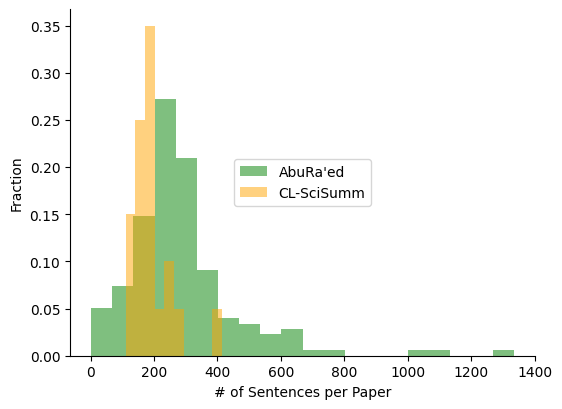

In [90]:
fig, ax = plt.subplots(figsize=(6,4.5))
A_hist = ax.hist(n_sentences, weights=np.ones(len(n_sentences)) / len(n_sentences), color="green", alpha=0.5, bins=20)
scisumm_hist = ax.hist(scisumm_n_sentences, weights=np.ones(len(scisumm_n_sentences)) / len(scisumm_n_sentences), alpha=0.5, color="orange", bins=10)

# Add a legend
plt.legend(("AbuRa'ed", 'CL-SciSumm'), loc='center')

plt.xlabel('# of Sentences per Paper')
plt.ylabel('Fraction')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
#plt.show()
plt.savefig("paper_lengths.pdf",dpi=600,bbox_inches='tight')

In [19]:
use_stemmer = True

targets = []
concat_annotated_CTS = []
for citation_id, citation in CTS_by_citation.items():
    targets.append(remove_stop_words(citation["citing_sentence"]))
    concat_annotated = ""
    for sent in citation["all_support_sentences"]:
        concat_annotated += remove_stop_words(sent)
    concat_annotated_CTS.append(concat_annotated)

annotated_rouge_recall = ROUGE_recall(concat_annotated_CTS, targets, use_stemmer=use_stemmer)
annotated_rouge = ROUGE(concat_annotated_CTS, targets, use_stemmer=use_stemmer)

print(annotated_rouge_recall)
print(annotated_rouge)

{'rouge1': 45.6574, 'rouge2': 12.3712, 'rougeL': 32.8036, 'rougeLsum': 32.8461}
{'rouge1': 12.0101, 'rouge2': 3.5035, 'rougeL': 8.6414, 'rougeLsum': 8.699}


In [91]:
use_stemmer = True
hit_1_recall = []
hit_each_recall = []
hit_1_precision = []
hit_each_precision = []
for k in range(1, 41):
    hit = 0
    total_hit = 0
    total_n = 0
    total_k = 0
    total = 0
    targets = []
    concat_retrieved_CTS = []
    for citation_id, citation in CTS_by_citation.items():
        targets.append(remove_stop_words(citation["citing_sentence"]))
        retrieved_sentences = citation["sorted_support_sentences"][:k]
        retrieved_sentences = set(retrieved_sentences)
        n_hit = len(retrieved_sentences.intersection(citation["all_support_sentences"]))
        n_overlap = len(set(citation["sorted_support_sentences"]).intersection(citation["all_support_sentences"]))
        if n_hit > 0:
            hit += 1
        total_hit += n_hit
        if n_overlap > 0:
            total_k += k
            total_n += 1
            total += n_overlap
    hit_1_recall.append(round(hit/total_n,4))
    hit_each_recall.append(round(total_hit/total,4))
    hit_1_precision.append(round(hit/total_k,4))
    hit_each_precision.append(round(total_hit/total_k,4))

In [93]:
hit_each_precision

[0.2946,
 0.2868,
 0.261,
 0.2461,
 0.2558,
 0.2403,
 0.2359,
 0.2335,
 0.2283,
 0.2217,
 0.2163,
 0.2106,
 0.2027,
 0.1955,
 0.1922,
 0.187,
 0.1838,
 0.183,
 0.1807,
 0.1775,
 0.1739,
 0.1709,
 0.1702,
 0.1673,
 0.1653,
 0.1652,
 0.1628,
 0.1595,
 0.1569,
 0.1558,
 0.1535,
 0.1514,
 0.1487,
 0.1473,
 0.1449,
 0.1441,
 0.1427,
 0.1424,
 0.1409,
 0.1384]

In [92]:
hit_1_precision

[0.2946,
 0.2364,
 0.1938,
 0.1609,
 0.1473,
 0.124,
 0.1096,
 0.0979,
 0.0896,
 0.0822,
 0.0768,
 0.0717,
 0.0662,
 0.062,
 0.0599,
 0.0562,
 0.0538,
 0.0517,
 0.049,
 0.0469,
 0.0447,
 0.043,
 0.0411,
 0.0394,
 0.0378,
 0.0367,
 0.0353,
 0.0341,
 0.0331,
 0.032,
 0.031,
 0.0303,
 0.0294,
 0.0285,
 0.0277,
 0.0271,
 0.0266,
 0.0259,
 0.0252,
 0.0246]

In [20]:
use_stemmer = True
hit_1_recall = []
hit_each_recall = []
retrieved_recalls = []
retrieved_f1s = []
for k in range(1, 41):
    hit = 0
    total_hit = 0
    total_n = 0
    total = 0
    targets = []
    concat_retrieved_CTS = []
    for citation_id, citation in CTS_by_citation.items():
        targets.append(remove_stop_words(citation["citing_sentence"]))
        retrieved_sentences = citation["sorted_support_sentences"][:k]
        
        concat_retrieved = ""
        for sent in retrieved_sentences:
            concat_retrieved += remove_stop_words(sent)
        concat_retrieved_CTS.append(concat_retrieved)
        
        retrieved_sentences = set(retrieved_sentences)
        n_hit = len(retrieved_sentences.intersection(citation["all_support_sentences"]))
        n_overlap = len(set(citation["sorted_support_sentences"]).intersection(citation["all_support_sentences"]))
        if n_hit > 0:
            hit += 1
        total_hit += n_hit
        if n_overlap > 0:
            total_n += 1
            total += n_overlap
    hit_1_recall.append(round(hit/total_n,4))
    hit_each_recall.append(round(total_hit/total,4))
    
    retrieved_rouge_recall = ROUGE_recall(concat_retrieved_CTS, targets, use_stemmer=use_stemmer)
    retrieved_recalls.append(retrieved_rouge_recall)
    retrieved_rouge = ROUGE(concat_retrieved_CTS, targets, use_stemmer=use_stemmer)
    retrieved_f1s.append(retrieved_rouge)
    print(k, retrieved_rouge_recall, retrieved_rouge)

1 {'rouge1': 23.466, 'rouge2': 9.5103, 'rougeL': 18.9756, 'rougeLsum': 19.0395} {'rouge1': 23.4639, 'rouge2': 9.7309, 'rougeL': 19.077, 'rougeLsum': 19.1378}
2 {'rouge1': 32.1261, 'rouge2': 12.1363, 'rougeL': 24.044, 'rougeLsum': 24.1342} {'rouge1': 22.4087, 'rouge2': 8.3969, 'rougeL': 16.525, 'rougeLsum': 16.5607}
3 {'rouge1': 37.5973, 'rouge2': 13.6974, 'rougeL': 26.4312, 'rougeLsum': 26.5479} {'rouge1': 19.9838, 'rouge2': 7.1586, 'rougeL': 13.9585, 'rougeLsum': 13.9828}
4 {'rouge1': 41.1112, 'rouge2': 14.4141, 'rougeL': 29.224, 'rougeLsum': 29.2963} {'rouge1': 17.6213, 'rouge2': 6.0264, 'rougeL': 12.3399, 'rougeLsum': 12.3459}
5 {'rouge1': 43.9379, 'rouge2': 15.1208, 'rougeL': 31.3745, 'rougeLsum': 31.4114} {'rouge1': 15.9257, 'rouge2': 5.2821, 'rougeL': 11.0949, 'rougeLsum': 11.1029}
6 {'rouge1': 46.6242, 'rouge2': 15.9646, 'rougeL': 33.1273, 'rougeLsum': 33.1777} {'rouge1': 14.8968, 'rouge2': 4.876, 'rougeL': 10.2738, 'rougeLsum': 10.2805}
7 {'rouge1': 47.8008, 'rouge2': 16.4403, 

In [21]:
hit_1_recall_scisumm = [0.260989010989011,
 0.32005494505494503,
 0.3708791208791209,
 0.4100274725274725,
 0.4472527472527473,
 0.47893772893772896,
 0.5070643642072213,
 0.5336538461538461,
 0.5567765567765568,
 0.5766483516483516,
 0.5951548451548452,
 0.6130952380952381,
 0.6297548605240912,
 0.6452119309262166,
 0.6593406593406593,
 0.6723901098901099,
 0.6840659340659341,
 0.6949023199023199,
 0.7050318102949682,
 0.7142857142857143,
 0.7227891156462585,
 0.7307692307692307,
 0.7386526516961299,
 0.7461080586080586,
 0.7530769230769231,
 0.7596153846153846,
 0.7658730158730159,
 0.7716836734693877,
 0.7770935960591133,
 0.7822344322344322,
 0.7873094647288196,
 0.7920673076923077,
 0.7965367965367965,
 0.8008241758241759,
 0.804945054945055,
 0.8088369963369964,
 0.8125185625185625,
 0.8160063620589937,
 0.8193857424626655,
 0.8225961538461538]

In [22]:
hit_each_recall_scisumm = [0.10474090407938258,
 0.13616317530319735,
 0.16427783902976847,
 0.1868798235942668,
 0.20992282249173097,
 0.23116501286291805,
 0.25043313907702003,
 0.26888092613009923,
 0.28567928457674874,
 0.30066152149944875,
 0.31462363435902574,
 0.3282800441014333,
 0.341616487151217,
 0.3542290124429044,
 0.3664829106945976,
 0.37816979051819183,
 0.38926000389130294,
 0.40003675119441384,
 0.4106075552718621,
 0.421058434399118,
 0.4310915104740904,
 0.4406134108449434,
 0.45002636498729687,
 0.45916023520764426,
 0.46804851157662625,
 0.4769315579679417,
 0.4855649475274613,
 0.49397542920144905,
 0.5018819146105007,
 0.5094818081587652,
 0.5169826083863854,
 0.5242213340683572,
 0.5313554508703351,
 0.5383617614631299,
 0.5451567175933217,
 0.5516660541467597,
 0.5580023242647278,
 0.5640631346834561,
 0.569954485059226,
 0.575606394707828]

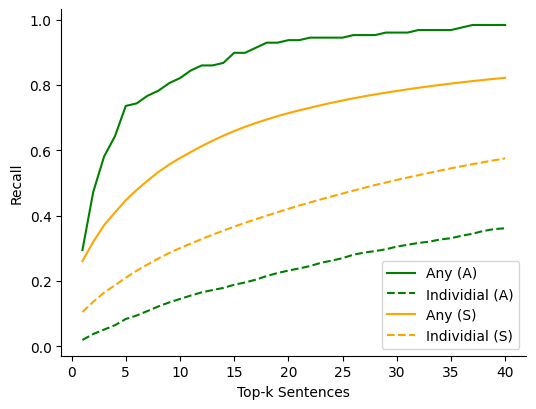

In [59]:
fig, ax = plt.subplots(figsize=(6,4.5))
hit_any, = plt.plot(np.arange(1,len(hit_1_recall)+1), hit_1_recall, color="green")
hit_individual, = plt.plot(np.arange(1,len(hit_1_recall)+1), hit_each_recall, color="green", linestyle="--")
hit_any_scisumm, = plt.plot(np.arange(1,len(hit_1_recall)+1), hit_1_recall_scisumm, color="orange")
hit_individual_scisumm, = plt.plot(np.arange(1,len(hit_1_recall)+1), hit_each_recall_scisumm, color="orange", linestyle="--")
plt.legend([hit_any, hit_individual, hit_any_scisumm, hit_individual_scisumm],
           ["Any (A)", "Individial (A)", "Any (S)", "Individial (S)",], loc="best")
#plt.title("Histogram of the len of dominant & reference spans w/o citation marks")
plt.xlabel('Top-k Sentences')
plt.ylabel('Recall')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
#plt.show()
plt.savefig("rouge_annotation_recall.pdf",dpi=600,bbox_inches='tight')

In [67]:
top_display = 10
rougeL = [result["rougeL"] / 100 for result in retrieved_f1s][:top_display]
rougeL_recall = [result["rougeL"] / 100 for result in retrieved_recalls][:top_display]
scisumm_rougeL = [result["rougeL"] / 100 for result in scisumm_result][:top_display]
scisumm_rougeL_recall = [result["rougeL"] / 100 for result in scisumm_result_recall][:top_display]

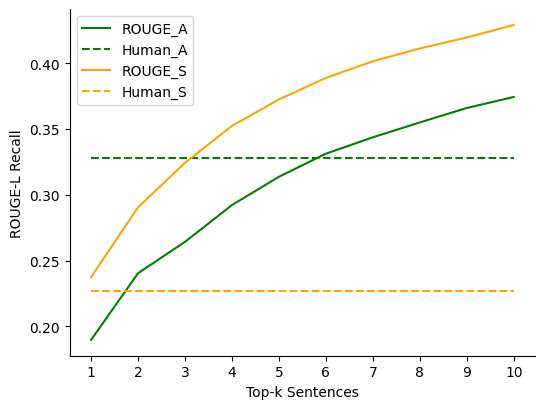

In [69]:
fig, ax = plt.subplots(figsize=(6,4.5))
human_A_recall, = plt.plot(np.arange(1,len(rougeL)+1), [annotated_rouge_recall["rougeL"]/ 100] * len(rougeL), color="green", linestyle="--")
rougeL_A_recall, = plt.plot(np.arange(1,len(rougeL)+1), rougeL_recall, color="green")
human_S_recall, = plt.plot(np.arange(1,len(rougeL)+1), [scisumm_annotated_rouge_recall["rougeL"]/ 100] * len(rougeL), color="orange", linestyle="--")
rougeL_S_recall, = plt.plot(np.arange(1,len(rougeL)+1), scisumm_rougeL_recall, color="orange")
plt.legend([rougeL_A_recall, human_A_recall,  rougeL_S_recall, human_S_recall],
           ["ROUGE_A","Human_A", "ROUGE_S","Human_S"], loc="best")
#plt.title("Histogram of the len of dominant & reference spans w/o citation marks")
plt.xlabel('Top-k Sentences')
plt.ylabel('ROUGE-L Recall')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#plt.show()
plt.savefig("human_annotation_rouge.pdf",dpi=600,bbox_inches='tight')

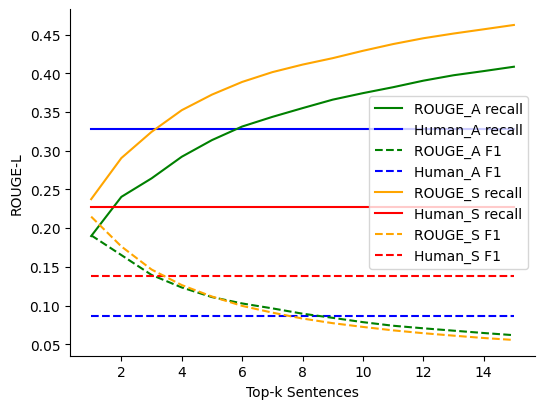

In [63]:
fig, ax = plt.subplots(figsize=(6,4.5))
human_A, = plt.plot(np.arange(1,len(rougeL)+1), [annotated_rouge["rougeL"] / 100 ] * len(rougeL), color="blue", linestyle="--")
rougeL_A, = plt.plot(np.arange(1,len(rougeL)+1), rougeL, color="green", linestyle="--")
human_A_recall, = plt.plot(np.arange(1,len(rougeL)+1), [annotated_rouge_recall["rougeL"]/ 100] * len(rougeL), color="blue")
rougeL_A_recall, = plt.plot(np.arange(1,len(rougeL)+1), rougeL_recall, color="green")
human_S, = plt.plot(np.arange(1,len(rougeL)+1), [scisumm_annotated_rouge["rougeL"] / 100 ] * len(rougeL), color="red", linestyle="--")
rougeL_S, = plt.plot(np.arange(1,len(rougeL)+1), scisumm_rougeL, color="orange", linestyle="--")
human_S_recall, = plt.plot(np.arange(1,len(rougeL)+1), [scisumm_annotated_rouge_recall["rougeL"]/ 100] * len(rougeL), color="red")
rougeL_S_recall, = plt.plot(np.arange(1,len(rougeL)+1), scisumm_rougeL_recall, color="orange")
plt.legend([rougeL_A_recall, human_A_recall, rougeL_A, human_A, rougeL_S_recall, human_S_recall, rougeL_S, human_S],
           ["ROUGE_A recall","Human_A recall","ROUGE_A F1","Human_A F1", "ROUGE_S recall","Human_S recall","ROUGE_S F1","Human_S F1"], loc="best")
#plt.title("Histogram of the len of dominant & reference spans w/o citation marks")
plt.xlabel('Top-k Sentences')
plt.ylabel('ROUGE-L')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
#plt.savefig("human_annotation_vs_target.pdf",dpi=600,bbox_inches='tight')


In [39]:
with open("cl_scisumm_citation_text_dataset.json") as f:
    cl_scisumm_citation_text_dataset = json.load(f)

In [41]:
targets = []
all_annotated_CTS = []
for cited_paper_name, citations in cl_scisumm_citation_text_dataset.items():
    for citation_id, citation in citations.items():
        targets.append(remove_stop_words(citation["citation_text"]))
        annotated_CTS = []
        for author, CTS in citation["annotated_CTS"].items():
            annotated_CTS.extend(CTS)
        annotated_CTS = list(set(annotated_CTS))
        annotated_CTS = [remove_stop_words(CTS) for CTS in annotated_CTS]
        all_annotated_CTS.append(" ".join(annotated_CTS))
        
scisumm_annotated_rouge_recall = ROUGE_recall(all_annotated_CTS, targets, use_stemmer=use_stemmer)
scisumm_annotated_rouge = ROUGE(all_annotated_CTS, targets, use_stemmer=use_stemmer)

print(scisumm_annotated_rouge_recall)
print(scisumm_annotated_rouge)

{'rouge1': 29.8999, 'rouge2': 8.4295, 'rougeL': 22.7046, 'rougeLsum': 22.7328}
{'rouge1': 18.2268, 'rouge2': 5.3775, 'rougeL': 13.8277, 'rougeLsum': 13.8038}


In [43]:
scisumm_result_recall = []
scisumm_result = []

for k in range(1,40):
    #targets = []
    all_retrieved_CTS = []
    for cited_paper_name, citations in cl_scisumm_citation_text_dataset.items():
        for citation_id, citation in citations.items():
            #targets.append(remove_stop_words(citation["citation_text"]))
            retrieved_CTS = [remove_stop_words(CTS) for CTS in citation["rouge_ranked_CTS"][:k]]
            all_retrieved_CTS.append(" ".join(retrieved_CTS))

    scisumm_rouge_recall = ROUGE_recall(all_retrieved_CTS, targets, use_stemmer=use_stemmer)
    scisumm_rouge = ROUGE(all_retrieved_CTS, targets, use_stemmer=use_stemmer)
    scisumm_result_recall.append(scisumm_rouge_recall)
    scisumm_result.append(scisumm_rouge)
    print(k)
    print(scisumm_rouge_recall)
    print(scisumm_rouge)

1
{'rouge1': 28.8476, 'rouge2': 12.2007, 'rougeL': 23.7433, 'rougeLsum': 23.7269}
{'rouge1': 26.1235, 'rouge2': 11.3111, 'rougeL': 21.4887, 'rougeLsum': 21.4612}
2
{'rouge1': 37.7591, 'rouge2': 15.2164, 'rougeL': 29.0556, 'rougeLsum': 29.0259}
{'rouge1': 23.0609, 'rouge2': 9.1876, 'rougeL': 17.6378, 'rougeLsum': 17.6156}
3
{'rouge1': 43.2507, 'rouge2': 16.7559, 'rougeL': 32.438, 'rougeLsum': 32.408}
{'rouge1': 19.589, 'rouge2': 7.3945, 'rougeL': 14.6571, 'rougeLsum': 14.635}
4
{'rouge1': 46.3611, 'rouge2': 17.6933, 'rougeL': 35.2382, 'rougeLsum': 35.1987}
{'rouge1': 16.8071, 'rouge2': 6.2282, 'rougeL': 12.6473, 'rougeLsum': 12.6282}
5
{'rouge1': 49.4606, 'rouge2': 18.4385, 'rougeL': 37.249, 'rougeLsum': 37.1957}
{'rouge1': 15.0357, 'rouge2': 5.4124, 'rougeL': 11.1693, 'rougeLsum': 11.1547}
6
{'rouge1': 52.1866, 'rouge2': 19.0917, 'rougeL': 38.8874, 'rougeLsum': 38.8894}
{'rouge1': 13.5652, 'rouge2': 4.78, 'rougeL': 9.9599, 'rougeLsum': 9.9364}
7
{'rouge1': 53.7521, 'rouge2': 19.5542, '